In [1]:
pip install ipywidgets --user


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jupyter --user

Note: you may need to restart the kernel to use updated packages.


In [3]:
import datetime as dt
from datetime import date
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import math
from tqdm import tqdm

# Data Input, EDA & Preprocessing

## Individual Data Input

In [4]:
price_vol = pd.read_csv('Price & Volume BTC.csv')
tweets = pd.read_csv('Tweets.csv')
funding_rates_1600 = pd.read_csv('Funding Rates BTCUSDT 1600.csv')
funding_rates_0800 = pd.read_csv('Funding Rates BTCUSDT 0800.csv')
funding_rates_0000 = pd.read_csv('Funding Rates BTCUSDT 0000.csv')
google = pd.read_csv('Google.csv')
transactions = pd.read_csv('Transactions.csv')
unique_addresses = pd.read_csv('Unique Addresses.csv')
active_addresses = pd.read_csv('Active Addresses.csv')

## Data Compilation

In [5]:
# get daily ave value for twitter attributes
tweets = tweets.groupby(by="Time").mean()
tweets = tweets.reset_index()

df = pd.merge(price_vol, funding_rates_0000, on=['Time'])
df = pd.merge(df, funding_rates_0800, on=['Time'])
df = pd.merge(df, funding_rates_1600, on=['Time'])
df = pd.merge(df, google, on=['Time'])
df = pd.merge(df, active_addresses, on=['Time'])
df = pd.merge(df, unique_addresses, on=['Time'])
df = pd.merge(df, transactions, on=['Time'])
df = pd.merge(df, tweets, how="outer")
df.head()

,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2022-03-03,43896.8,42456.3,44088.0,41832.0,324545814.8,0.01%,0.01%,0.01%,13.84,24.08,1011448,701198.0,268244.0,443.269231,79.576923,0.109327,0.036269,0.063731,0.900000
1,2022-03-02,44428.2,43896.9,45367.5,43332.8,340460526.5,0.00%,0.00%,0.01%,15.61,26.33,1091796,731603.0,288657.0,534.200000,90.366667,0.068437,0.037100,0.068967,0.893967
2,2022-03-01,43174.8,44428.2,44966.0,42796.9,444858241.2,-0.01%,0.01%,0.01%,17.67,29.34,1065354,722863.0,280634.0,353.514286,61.028571,0.006329,0.062714,0.070200,0.867114
3,2022-02-28,37706.7,43179.8,44210.4,37446.5,564121052.5,0.00%,-0.02%,-0.01%,16.20,24.83,981066,702483.0,270918.0,332.333333,61.861111,0.135383,0.033806,0.073306,0.892861
4,2022-02-27,39117.3,37706.7,39864.0,36977.4,388368905.7,0.01%,0.01%,0.00%,12.96,21.07,768705,583361.0,211164.0,128.000000,30.000000,0.106867,0.022667,0.055000,0.922333


In [6]:
print("Type of variables: ", "\n", df.dtypes)

Type of variables:  
 Time                        object
Open                       float64
Close                      float64
High                       float64
Low                        float64
Volume                     float64
Funding Rate 0000           object
Funding Rate 0800           object
Funding Rate 1600           object
Bitcoin_SVI                float64
Cryptocurrency_SVI         float64
No. of Active Addresses      int64
No. of Unique Addresses    float64
Transactions               float64
Favorites                  float64
Retweets                   float64
Compound                   float64
Negative                   float64
Positive                   float64
Neutral                    float64
dtype: object


# Preprocessing

## Data Type Transformation

In [7]:
# Transform object type of "Funding Rate 0000", "Funding Rate 0800" and " Funding Rate 1600" to numerical type
df['Funding Rate 0000'] = df['Funding Rate 0000'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 0800'] = df['Funding Rate 0800'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))
df['Funding Rate 1600'] = df['Funding Rate 1600'].map(lambda x: float('nan') if pd.isnull(x) else float(x.replace('%','')))

df['Month'] = df['Time'].str[:7]
df['Time2'] = df['Time'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['Month'] = df['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
df['FundingRate'] = (df['Funding Rate 1600'] + df['Funding Rate 0800'] + df['Funding Rate 0000'])/3 
df = df.sort_values(by = 'Time', ascending=True).reset_index(drop=True)
df.head(10)


,Time,Open,Close,High,Low,Volume,Funding Rate 0000,Funding Rate 0800,Funding Rate 1600,Bitcoin_SVI,...,Transactions,Favorites,Retweets,Compound,Negative,Positive,Neutral,Month,Time2,FundingRate
0,2020-03-04,8761.2,8750.7,8847.1,8655.7,1.221924e+07,0.01,0.01,0.01,8.64,...,358745.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200304,0.010000
1,2020-03-05,8750.8,9056.9,9153.1,8750.7,1.521845e+07,0.02,0.01,0.02,9.26,...,349529.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200305,0.016667
2,2020-03-06,9056.2,9134.3,9168.7,8989.1,8.833555e+06,0.02,0.02,0.02,8.95,...,338383.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200306,0.020000
3,2020-03-07,9133.9,8889.9,9184.9,8789.8,7.525135e+06,0.04,0.04,0.03,7.10,...,313312.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200307,0.036667
4,2020-03-08,8889.9,8036.5,8889.9,8001.1,1.439716e+07,0.03,0.05,0.05,8.02,...,302694.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200308,0.043333
5,2020-03-09,8035.0,7931.3,8175.2,7636.3,2.070482e+07,0.04,0.01,0.01,16.05,...,348211.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200309,0.020000
6,2020-03-10,7931.4,7895.3,8147.1,7736.9,1.365059e+07,0.01,0.01,0.01,12.34,...,329698.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200310,0.010000
7,2020-03-11,7895.4,7933.2,8000.0,7590.0,1.145017e+07,0.01,0.01,0.01,10.49,...,287492.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200311,0.010000
8,2020-03-12,7933.2,4802.9,7960.4,4448.6,5.524836e+07,0.02,0.01,0.01,22.83,...,349978.0,5.0,2.0,0.0772,0.091,0.1,0.809,202003,20200312,0.013333
9,2020-03-13,4811.8,5576.3,5950.0,3800.0,6.423345e+07,-0.02,-0.02,-0.30,30.86,...,276798.0,NaN,NaN,NaN,NaN,NaN,NaN,202003,20200313,-0.113333


## Handle Missing Data

In [8]:
# Count missing value
print(df.isna().sum())

Time                         0
Open                         0
Close                        0
High                         0
Low                          0
Volume                       0
Funding Rate 0000            0
Funding Rate 0800            0
Funding Rate 1600            0
Bitcoin_SVI                  0
Cryptocurrency_SVI           0
No. of Active Addresses      0
No. of Unique Addresses      2
Transactions                 0
Favorites                  458
Retweets                   458
Compound                   458
Negative                   458
Positive                   458
Neutral                    458
Month                        0
Time2                        0
FundingRate                  0
dtype: int64


### Monthly Sentiment Analysis

In [9]:
tweets.insert(1, "Month", "NaN")

tweets['Month'] = tweets['Time'].str[:7]
tweets['Month'] = tweets['Month'].map(lambda x: int('nan') if pd.isnull(x) else int(x.replace("-", "")))
tweets.head(10)

,Time,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,2020-03-12,202003,5.0,2.0,0.0772,0.091,0.100,0.809
1,2020-03-17,202003,98.0,96.0,0.4019,0.000,0.114,0.886
2,2020-03-20,202003,125.0,95.0,0.4767,0.000,0.146,0.854
3,2020-03-30,202003,3.0,0.0,0.0803,0.061,0.071,0.869
4,2020-03-31,202003,186.0,142.0,0.6597,0.000,0.278,0.722
5,2020-04-01,202004,171.0,120.0,0.5267,0.061,0.184,0.754
6,2020-04-16,202004,419.0,94.0,0.0000,0.000,0.000,1.000
7,2020-04-22,202004,73.0,18.0,0.3182,0.000,0.084,0.916
8,2020-04-30,202004,994.0,153.0,0.0000,0.000,0.000,1.000
9,2020-05-09,202005,35.0,2.0,0.0000,0.000,0.000,1.000


In [10]:
tweets = tweets.groupby(by="Month").mean()
tweets = tweets.reset_index()

In [11]:
tweets.head(10)

,Month,Favorites,Retweets,Compound,Negative,Positive,Neutral
0,202003,83.400000,67.000000,0.339160,0.030400,0.141800,0.828000
1,202004,414.250000,96.250000,0.211225,0.015250,0.067000,0.917500
2,202005,283.285714,49.142857,0.002414,0.027857,0.057429,0.914571
3,202006,232.000000,155.000000,0.401900,0.000000,0.072000,0.928000
4,202007,303.750000,79.000000,0.227450,0.000000,0.065250,0.934750
5,202008,1103.925926,241.740741,0.379407,0.016296,0.146444,0.837407
6,202009,63.500000,17.000000,0.121117,0.000000,0.035000,0.965000
7,202010,300.000000,50.000000,0.405267,0.000000,0.146000,0.854000
8,202011,254.666667,37.833333,0.117625,0.049250,0.123000,0.827750
9,202012,487.428571,56.571429,0.133693,0.058571,0.110143,0.831286


In [12]:
overall_df = pd.DataFrame(columns = ['Time', 'Month', 'Time2', 'Compound', \
                                 'Close', 'Volume', 'FundingRate', \
                             'Bitcoin_SVI', 'Cryptocurrency_SVI',  'No. of Active Addresses', \
                                 'No. of Unique Addresses', 'Transactions'])

for i, row in df.iterrows():
    if (pd.isna(df.loc[i].at["Favorites"])):
        data = tweets[tweets['Month'] == df.loc[i].at["Month"]]
        new_row = {'Time': df.loc[i].at["Time"],'Time2': df.loc[i].at["Time2"], 'Month': df.loc[i].at["Month"],  'Compound': data.Compound.values[0], \
                    
                 'Close': df.loc[i].at["Close"], 'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)
    else:
        new_row = {'Time': df.loc[i].at["Time"], 'Time2': df.loc[i].at["Time2"],'Month': df.loc[i].at["Month"], 'Compound': df.loc[i].at["Compound"], \
                  
                 'Close': df.loc[i].at["Close"],'Volume': df.loc[i].at["Volume"], 'FundingRate': df.loc[i].at["FundingRate"], \
                  'Bitcoin_SVI': df.loc[i].at["Bitcoin_SVI"], \
                   'Cryptocurrency_SVI': df.loc[i].at["Cryptocurrency_SVI"], 'No. of Active Addresses': df.loc[i].at["No. of Active Addresses"], 'No. of Unique Addresses': df.loc[i].at["No. of Unique Addresses"], \
                   'Transactions': df.loc[i].at["Transactions"]}
        overall_df = overall_df.append(new_row, ignore_index=True)


/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3795/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3795/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3795/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  overall_df = overall_df.append(new_row, ignore_index=True)
/var/folders/t1/pxny3xn56cd89t4tpk4s00vc0000gn/T/ipykernel_3795/710371745.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [13]:
overall_df = overall_df.drop(['Month'], axis = 1)
overall_df.head(10)

,Time,Time2,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04,20200304,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05,20200305,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06,20200306,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07,20200307,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08,20200308,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09,20200309,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10,20200310,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11,20200311,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12,20200312,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13,20200313,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [14]:
from datetime import datetime

for i in range(len(overall_df)): 
    overall_df.loc[i, 'Time'] = datetime.strptime(overall_df.loc[i, 'Time'], '%Y-%m-%d')


In [15]:
overall_df.drop(columns=['Time2'], inplace=True)
overall_df.head(10)

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions
0,2020-03-04 00:00:00,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
1,2020-03-05 00:00:00,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
2,2020-03-06 00:00:00,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
3,2020-03-07 00:00:00,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
4,2020-03-08 00:00:00,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0
5,2020-03-09 00:00:00,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0
6,2020-03-10 00:00:00,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0
7,2020-03-11 00:00:00,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0
8,2020-03-12 00:00:00,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0
9,2020-03-13 00:00:00,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0


In [16]:
test_size = 0.2                                                # proportion of dataset to be used as test set
cv_size = 0.2                                                   # proportion of dataset to be used as cross-validation set
N = 5                                                              # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100                          # Number of boosted trees to fit. default = 100
max_depth = 3                               # Maximum tree depth for base learners. default = 3
learning_rate = 0.1                         # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1                     # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

In [17]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() 
    std_list = df[col].rolling(window = N, min_periods=1).std()   
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

Text(0.5, 1.0, 'Price of BTC From 4th March 2020 to 3rd March 2022')

<Figure size 1440x720 with 0 Axes>

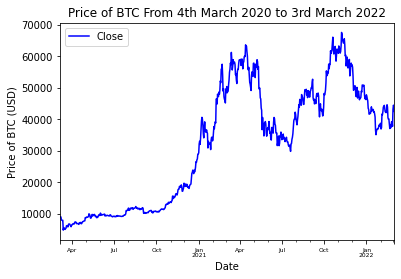

In [18]:
fig = plt.figure(figsize=(20,10))
ax  = overall_df.plot(x = 'Time',y = 'Close', style = 'b-')
plt.xlabel('Date')
plt.xticks(fontsize=6 ) 
plt.ylabel('Price of BTC (USD)')
plt.title("Price of BTC From 4th March 2020 to 3rd March 2022")

In [19]:
print(overall_df.isna().sum())
overall_df1 = overall_df.copy()

Time                       0
Compound                   0
Close                      0
Volume                     0
FundingRate                0
Bitcoin_SVI                0
Cryptocurrency_SVI         0
No. of Active Addresses    0
No. of Unique Addresses    2
Transactions               0
dtype: int64


In [20]:
lag_cols = list(overall_df.columns)[1:]
merging_keys = ['day']

In [21]:
lag_cols

['Compound',
 'Close',
 'Volume',
 'FundingRate',
 'Bitcoin_SVI',
 'Cryptocurrency_SVI',
 'No. of Active Addresses',
 'No. of Unique Addresses',
 'Transactions']

In [22]:
overall_df['day'] = [x for x in list(range(len(overall_df)))]
overall_df

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,day
0,2020-03-04 00:00:00,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0,0
1,2020-03-05 00:00:00,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0,1
2,2020-03-06 00:00:00,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0,2
3,2020-03-07 00:00:00,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0,3
4,2020-03-08 00:00:00,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0,4
...,...,...,...,...,...,...,...,...,...,...,...
725,2022-02-27 00:00:00,0.106867,37706.7,388368905.7,0.006667,12.96,21.07,768705,583361.0,211164.0,725
726,2022-02-28 00:00:00,0.135383,43179.8,564121052.5,-0.01,16.2,24.83,981066,702483.0,270918.0,726
727,2022-03-01 00:00:00,0.006329,44428.2,444858241.2,0.003333,17.67,29.34,1065354,722863.0,280634.0,727
728,2022-03-02 00:00:00,0.068437,43896.9,340460526.5,0.003333,15.61,26.33,1091796,731603.0,288657.0,728


# Identifying Correlations 

<Figure size 1440x576 with 0 Axes>

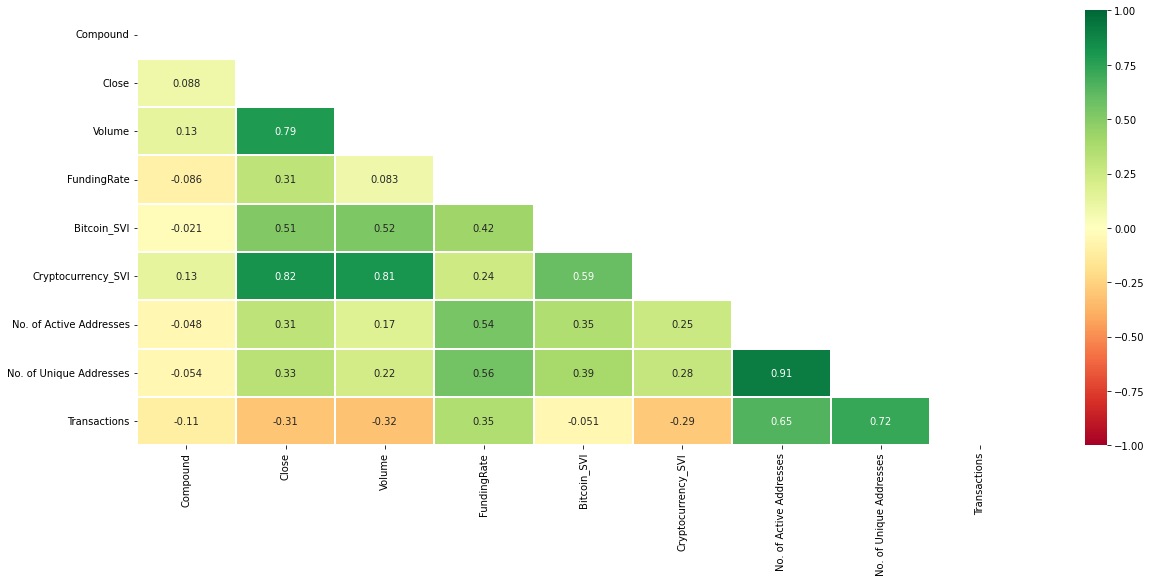

In [23]:
cols = list(overall_df.columns)[1:-1]
corr = overall_df[cols].astype(float).corr()
plt.figure(figsize=(20,8))
plt.figure(figsize=(20,8))
#returns an array of given shape and type as given array, with zeros
mask = np.zeros_like(corr)

# Return the indices for the upper-triangle of arr and makes it true
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=1.5,annot = True)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()


# Creating Lagging Features (Up to 5 Days)

In [24]:
from tqdm.notebook import tqdm_notebook

shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    
    train_shift = overall_df[merging_keys + lag_cols].copy()
    train_shift['day'] = train_shift['day'] + shift
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)
    print(train_shift)
    overall_df = pd.merge(overall_df, train_shift, on=merging_keys, how='left') 
    
    
del train_shift

overall_df = overall_df[N:]
    
overall_df.head()

  0%|          | 0/5 [00:00<?, ?it/s]

     day Compound_lag_1 Close_lag_1 Volume_lag_1 FundingRate_lag_1  \
0      1        0.33916      8750.7  12219240.24              0.01   
1      2        0.33916      9056.9  15218448.72          0.016667   
2      3        0.33916      9134.3  8833554.543              0.02   
3      4        0.33916      8889.9  7525135.261          0.036667   
4      5        0.33916      8036.5  14397155.01          0.043333   
..   ...            ...         ...          ...               ...   
725  726       0.106867     37706.7  388368905.7          0.006667   
726  727       0.135383     43179.8  564121052.5             -0.01   
727  728       0.006329     44428.2  444858241.2          0.003333   
728  729       0.068437     43896.9  340460526.5          0.003333   
729  730       0.109327     42456.3  324545814.8              0.01   

    Bitcoin_SVI_lag_1 Cryptocurrency_SVI_lag_1 No. of Active Addresses_lag_1  \
0                8.64                     4.34                        857423   

,Time,Compound,Close,Volume,FundingRate,Bitcoin_SVI,Cryptocurrency_SVI,No. of Active Addresses,No. of Unique Addresses,Transactions,...,Transactions_lag_4,Compound_lag_5,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5
5,2020-03-09 00:00:00,0.33916,7931.3,20704818.48,0.02,16.05,5.16,809850,606002.0,348211.0,...,349529.0,0.33916,8750.7,12219240.24,0.01,8.64,4.34,857423,625096.0,358745.0
6,2020-03-10 00:00:00,0.33916,7895.3,13650591.37,0.01,12.34,4.44,807778,601526.0,329698.0,...,338383.0,0.33916,9056.9,15218448.72,0.016667,9.26,3.76,793221,603996.0,349529.0
7,2020-03-11 00:00:00,0.33916,7933.2,11450174.16,0.01,10.49,4.23,728889,528053.0,287492.0,...,313312.0,0.33916,9134.3,8833554.543,0.02,8.95,3.33,804945,601698.0,338383.0
8,2020-03-12 00:00:00,0.0772,4802.9,55248355.79,0.013333,22.83,6.2,909601,653156.0,349978.0,...,302694.0,0.33916,8889.9,7525135.261,0.036667,7.1,3.04,682432,526880.0,313312.0
9,2020-03-13 00:00:00,0.33916,5576.3,64233445.37,-0.113333,30.86,6.71,786409,NaN,276798.0,...,348211.0,0.33916,8036.5,14397155.01,0.043333,8.02,4.34,654911,501571.0,302694.0


In [25]:
lag_cols

['Compound',
 'Close',
 'Volume',
 'FundingRate',
 'Bitcoin_SVI',
 'Cryptocurrency_SVI',
 'No. of Active Addresses',
 'No. of Unique Addresses',
 'Transactions']

In [26]:
overall_df = get_mov_avg_std(overall_df, 'Close',N)
overall_df.columns

Index(['Time', 'Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'day', 'Compound_lag_1',
       'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1',
       'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1',
       'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2',
       'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2',
       'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2',
       'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3',
       'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3',
       'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3',
       'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4',
       'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4',
       'Cryptocurrency_SVI_la

In [27]:
overall_df.columns

Index(['Time', 'Compound', 'Close', 'Volume', 'FundingRate', 'Bitcoin_SVI',
       'Cryptocurrency_SVI', 'No. of Active Addresses',
       'No. of Unique Addresses', 'Transactions', 'day', 'Compound_lag_1',
       'Close_lag_1', 'Volume_lag_1', 'FundingRate_lag_1', 'Bitcoin_SVI_lag_1',
       'Cryptocurrency_SVI_lag_1', 'No. of Active Addresses_lag_1',
       'No. of Unique Addresses_lag_1', 'Transactions_lag_1', 'Compound_lag_2',
       'Close_lag_2', 'Volume_lag_2', 'FundingRate_lag_2', 'Bitcoin_SVI_lag_2',
       'Cryptocurrency_SVI_lag_2', 'No. of Active Addresses_lag_2',
       'No. of Unique Addresses_lag_2', 'Transactions_lag_2', 'Compound_lag_3',
       'Close_lag_3', 'Volume_lag_3', 'FundingRate_lag_3', 'Bitcoin_SVI_lag_3',
       'Cryptocurrency_SVI_lag_3', 'No. of Active Addresses_lag_3',
       'No. of Unique Addresses_lag_3', 'Transactions_lag_3', 'Compound_lag_4',
       'Close_lag_4', 'Volume_lag_4', 'FundingRate_lag_4', 'Bitcoin_SVI_lag_4',
       'Cryptocurrency_SVI_la

# Train-Test Split


In [28]:
#80-20 split - train-test 

train_size = 0.6 
test_size = 0.2                                              
val_size = 0.2                                                 
N = 5 #For time lag (to get previous days of data)  

In [29]:
num_val = int(val_size*len(overall_df))
num_test = int(test_size*len(overall_df))
num_train = len(overall_df) - num_val - num_test
print("num_train = " + str(num_train))
print("num_val = " + str(num_val))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = overall_df[:num_train]
val = overall_df[num_train:num_train+num_val]
train_val = overall_df[:num_train+num_val]
test = overall_df[num_train+num_val:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(val.shape))
print("train_cv.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

num_train = 435
num_val = 145
num_test = 145
train.shape = (435, 58)
cv.shape = (145, 58)
train_cv.shape = (580, 58)
test.shape = (145, 58)


In [30]:
train_time = train['Time']
test_time = test['Time']
val_time = val['Time']
train_val_time = train_val['Time']

train = train.drop(columns = ['Time'])
test = test.drop(columns = ['Time'])
val = val.drop(columns = ['Time'])
train_val = train_val.drop(columns = ['Time'])

# Select features, the target output is'Close'
feature_pool = train.columns
#Note : Close is a feature as well 

output = 'Close'

### NaN Values

In [31]:
print(train.isna().sum())
print(test.isna().sum())
print(val.isna().sum())
print(train_val.isna().sum())

Compound                         0
Close                            0
Volume                           0
FundingRate                      0
Bitcoin_SVI                      0
Cryptocurrency_SVI               0
No. of Active Addresses          0
No. of Unique Addresses          2
Transactions                     0
day                              0
Compound_lag_1                   0
Close_lag_1                      0
Volume_lag_1                     0
FundingRate_lag_1                0
Bitcoin_SVI_lag_1                0
Cryptocurrency_SVI_lag_1         0
No. of Active Addresses_lag_1    0
No. of Unique Addresses_lag_1    2
Transactions_lag_1               0
Compound_lag_2                   0
Close_lag_2                      0
Volume_lag_2                     0
FundingRate_lag_2                0
Bitcoin_SVI_lag_2                0
Cryptocurrency_SVI_lag_2         0
No. of Active Addresses_lag_2    0
No. of Unique Addresses_lag_2    2
Transactions_lag_2               0
Compound_lag_3      

In [32]:
KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train)
train = pd.DataFrame(KNN_miss_filling.transform(train))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(test)
test = pd.DataFrame(KNN_miss_filling.transform(test))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(train_val)
train_val = pd.DataFrame(KNN_miss_filling.transform(train_val))

KNN_miss_filling = KNNImputer(n_neighbors=5).fit(val)
val = pd.DataFrame(KNN_miss_filling.transform(val))


In [33]:
train.columns = feature_pool
test.columns = feature_pool
train_val.columns = feature_pool
val.columns = feature_pool

## Scale the train, dev and test set

In [34]:
# Standardized features:
standardized_features = ['Compound','Volume', 'Close', 'Close_mean', 'Close_std', 'Transactions', 'Cryptocurrency_SVI', 'Bitcoin_SVI','No. of Active Addresses', 'No. of Unique Addresses']     
for i in range(len(lag_cols)): 
    for j in range(1, N+1):
        standardized_features.append(lag_cols[i]+"_lag_"+ str(j))
non_standardized_features = list(set(train.columns)-set(standardized_features))
non_standardized_features



['day', 'FundingRate']

In [35]:
# Get the scaler based on train set
scaler = preprocessing.StandardScaler().fit(train[standardized_features])
print('The mean and variance of training set:', scaler.mean_, scaler.var_)

train_std=pd.DataFrame(scaler.fit_transform(train[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_nstd=pd.DataFrame(train[non_standardized_features])


train_std.columns = train_std.columns.map(lambda x: standardized_features[x])
train_std.reset_index(drop=True, inplace=True)
train_nstd.reset_index(drop=True, inplace=True)
train_scaled = pd.concat([train_std,train_nstd], sort=False,axis=1)

# Get the scaler based on cv set
scaler.val = preprocessing.StandardScaler().fit(val[standardized_features])
print('The mean and variance of val set:', scaler.val.mean_, scaler.val.var_)


val_std=pd.DataFrame(scaler.transform(val[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
val_nstd=pd.DataFrame(val[non_standardized_features])
val_std.columns = val_std.columns.map(lambda x: standardized_features[x])
val_std.reset_index(drop=True, inplace=True)
val_nstd.reset_index(drop=True, inplace=True)
val_scaled = pd.concat([val_std,val_nstd], sort=False,axis=1)


scaler_trainval = preprocessing.StandardScaler().fit(train_val[standardized_features])
print('The mean and variance of training cv set:', scaler_trainval.mean_, scaler_trainval.var_)


train_val_std=pd.DataFrame(scaler.transform(train_val[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
train_val_nstd=pd.DataFrame(train_val[non_standardized_features])
train_val_std.columns = train_val_std.columns.map(lambda x: standardized_features[x])
train_val_std.reset_index(drop=True, inplace=True)
train_val_nstd.reset_index(drop=True, inplace=True)
train_val_scaled = pd.concat([train_val_std,train_val_nstd], sort=False,axis=1)



scaler_test = preprocessing.StandardScaler().fit(test[standardized_features])
print('The mean and variance of test set:', scaler_test.mean_, scaler_test.var_)


test_std=pd.DataFrame(scaler.transform(test[standardized_features]))  # transform() return 'numpy.ndarray', not 'DataFrame' or 'Series'
test_nstd=pd.DataFrame(test[non_standardized_features])
test_std.columns = test_std.columns.map(lambda x: standardized_features[x])
test_std.reset_index(drop=True, inplace=True)
test_nstd.reset_index(drop=True, inplace=True)
test_scaled = pd.concat([test_std,test_nstd], sort=False,axis=1)


The mean and variance of training set: [2.41025156e-01 9.81899260e+07 2.33389349e+04 2.30761808e+04
 8.24600872e+02 3.04091101e+05 1.29212874e+01 1.25677701e+01
 9.95913864e+05 6.82150081e+05 2.40845820e-01 2.40666485e-01
 2.40504048e-01 2.41119282e-01 2.40939946e-01 2.32573207e+04
 2.31710276e+04 2.30844963e+04 2.29907225e+04 2.28966428e+04
 9.70366324e+07 9.60376732e+07 9.51859630e+07 9.45923283e+07
 9.34772648e+07 2.54099617e-02 2.54329502e-02 2.54482759e-02
 2.54099617e-02 2.53869732e-02 1.24643678e+01 1.23979310e+01
 1.23588276e+01 1.23041609e+01 1.22010575e+01 1.28094253e+01
 1.26853793e+01 1.25750115e+01 1.24636092e+01 1.23291264e+01
 9.95205651e+05 9.94540784e+05 9.94199720e+05 9.93572023e+05
 9.92812657e+05 6.81580562e+05 6.81340200e+05 6.81239216e+05
 6.80972843e+05 6.80242061e+05 3.04210145e+05 3.04425954e+05
 3.04670285e+05 3.04862179e+05 3.05051313e+05] [3.62373247e-02 1.37847719e+16 3.42852453e+08 3.39532588e+08
 8.35159347e+05 1.20922709e+09 2.26477029e+02 9.32651015e+01

In [36]:
# Update the order within feature pool
feature_pool = list(train.columns)[10:]

feature_pool

['Compound_lag_1',
 'Close_lag_1',
 'Volume_lag_1',
 'FundingRate_lag_1',
 'Bitcoin_SVI_lag_1',
 'Cryptocurrency_SVI_lag_1',
 'No. of Active Addresses_lag_1',
 'No. of Unique Addresses_lag_1',
 'Transactions_lag_1',
 'Compound_lag_2',
 'Close_lag_2',
 'Volume_lag_2',
 'FundingRate_lag_2',
 'Bitcoin_SVI_lag_2',
 'Cryptocurrency_SVI_lag_2',
 'No. of Active Addresses_lag_2',
 'No. of Unique Addresses_lag_2',
 'Transactions_lag_2',
 'Compound_lag_3',
 'Close_lag_3',
 'Volume_lag_3',
 'FundingRate_lag_3',
 'Bitcoin_SVI_lag_3',
 'Cryptocurrency_SVI_lag_3',
 'No. of Active Addresses_lag_3',
 'No. of Unique Addresses_lag_3',
 'Transactions_lag_3',
 'Compound_lag_4',
 'Close_lag_4',
 'Volume_lag_4',
 'FundingRate_lag_4',
 'Bitcoin_SVI_lag_4',
 'Cryptocurrency_SVI_lag_4',
 'No. of Active Addresses_lag_4',
 'No. of Unique Addresses_lag_4',
 'Transactions_lag_4',
 'Compound_lag_5',
 'Close_lag_5',
 'Volume_lag_5',
 'FundingRate_lag_5',
 'Bitcoin_SVI_lag_5',
 'Cryptocurrency_SVI_lag_5',
 'No. of Ac

In [37]:
output

'Close'

In [38]:
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)
train_val.to_csv('train_val.csv', index = False)
val.to_csv('val.csv', index = False)

# X and Y Datasets

In [39]:
X_train = train[feature_pool]
y_train = train[output]
X_val = val[feature_pool]
y_val = val[output]
X_train_val = train_val[feature_pool]
y_train_val = train_val[output]
X_test = test[feature_pool]
y_test = test[output]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_val.shape = " + str(X_val.shape))
print("y_val.shape = " + str(y_val.shape))
print("X_train_val.shape = " + str(X_train_val.shape))
print("y_train_val.shape = " + str(y_train_val.shape))
print("X_sample.shape = " + str(X_test.shape))
print("y_sample.shape = " + str(y_test.shape))

X_train.shape = (435, 47)
y_train.shape = (435,)
X_val.shape = (145, 47)
y_val.shape = (145,)
X_train_val.shape = (580, 47)
y_train_val.shape = (580,)
X_sample.shape = (145, 47)
y_sample.shape = (145,)


In [40]:
X_train_scaled = train_scaled[feature_pool]
y_train_scaled = train_scaled['Close']
X_val_scaled = val_scaled[feature_pool]
X_train_val_scaled = train_val_scaled[feature_pool]
y_train_val_scaled = train_val_scaled['Close']
X_test_scaled = test_scaled[feature_pool]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_val_scaled.shape = " + str(X_val_scaled.shape))
print("X_train_val_scaled.shape = " + str(X_train_val_scaled.shape))
print("y_train_val_scaled.shape = " + str(y_train_val_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))

X_train_scaled.shape = (435, 47)
y_train_scaled.shape = (435,)
X_val_scaled.shape = (145, 47)
X_train_val_scaled.shape = (580, 47)
y_train_val_scaled.shape = (580,)
X_test_scaled.shape = (145, 47)


In [41]:
X_train_scaled

,Compound_lag_1,Close_lag_1,Volume_lag_1,FundingRate_lag_1,Bitcoin_SVI_lag_1,Cryptocurrency_SVI_lag_1,No. of Active Addresses_lag_1,No. of Unique Addresses_lag_1,Transactions_lag_1,Compound_lag_2,...,Close_lag_5,Volume_lag_5,FundingRate_lag_5,Bitcoin_SVI_lag_5,Cryptocurrency_SVI_lag_5,No. of Active Addresses_lag_5,No. of Unique Addresses_lag_5,Transactions_lag_5,Close_mean,Close_std
0,0.516813,-0.822511,-0.713946,0.502136,-0.469669,-0.567230,-2.236249,-1.758620,-0.043718,0.518108,...,-0.768914,-0.725142,-0.430988,-0.390661,-0.556274,-0.883297,-0.537075,1.561199,-0.783822,-0.764793
1,0.516813,-0.828196,-0.659452,-0.151564,0.378920,-0.512311,-1.218066,-0.738372,1.268760,0.518108,...,-0.752270,-0.698377,-0.244255,-0.322645,-0.596659,-1.302158,-0.742571,1.293234,-0.821912,-0.767003
2,0.516813,-0.830142,-0.720396,-0.431721,-0.013143,-0.560532,-1.231682,-0.782100,0.734940,0.518108,...,-0.748063,-0.755355,-0.150889,-0.356653,-0.626599,-1.225670,-0.764951,0.969153,-0.822888,-0.874462
3,0.516813,-0.828094,-0.739406,-0.431721,-0.208646,-0.574597,-1.750102,-1.499901,-0.482066,0.518108,...,-0.761347,-0.767031,0.315943,-0.559604,-0.646792,-2.024958,-1.493614,0.240188,-0.822529,-0.878950
4,-0.860245,-0.997251,-0.361021,-0.338336,1.095413,-0.442658,-0.562552,-0.277696,1.319712,0.518108,...,-0.807735,-0.705706,0.502676,-0.458677,-0.556274,-2.204508,-1.740102,-0.068541,-0.864819,0.803192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,0.926897,1.426866,3.677197,0.035208,1.010871,2.995106,1.645435,1.673193,-0.108366,0.928472,...,1.954985,2.231053,0.502676,0.468318,5.625380,1.153707,0.622340,-0.882757,1.778814,3.111485
431,0.926897,1.427595,3.457747,-0.151564,4.335482,3.350737,1.265287,1.224144,-0.799827,0.928472,...,1.921670,2.177538,0.596042,0.991605,3.455743,1.576704,0.097498,-1.662722,1.679091,3.544057
432,-0.890033,1.436949,1.524082,0.221979,2.174379,2.639476,0.466993,0.691418,-1.100200,0.928472,...,1.789205,3.332021,0.969508,1.078271,3.455743,2.102945,1.407246,-0.051008,1.587899,3.018835
433,0.888255,1.270883,2.438792,-0.338336,1.426183,2.580539,-0.275331,-0.338825,-2.079318,-0.889696,...,1.836228,2.583068,1.062874,0.991605,3.332500,1.736114,1.698427,0.205384,1.489803,3.112502


In [42]:
X_train.to_csv('X_train.csv', index = False)
y_train.to_csv('y_train.csv', index = False)
X_val.to_csv('X_val.csv', index = False)
y_val.to_csv('y_val.csv', index = False)
X_train_val.to_csv('X_train_val.csv', index = False)
y_train_val.to_csv('y_train_val.csv', index = False)
X_test.to_csv('X_test.csv', index = False)
y_test.to_csv('y_test.csv', index = False)

X_train_scaled.to_csv('X_train_scaled.csv', index = False)
y_train_scaled.to_csv('y_train_scaled.csv', index = False)
X_val_scaled.to_csv('X_val_scaled.csv', index = False)
X_train_val_scaled.to_csv('X_train_val_scaled.csv', index = False)
y_train_val_scaled.to_csv('y_train_val_scaled.csv', index = False)
X_test_scaled.to_csv('X_test_scaled.csv', index = False)






# Outlier Detection

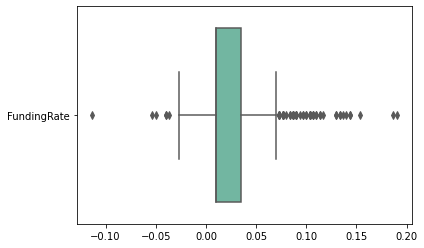

In [43]:
feature_Boxplot1 = ['FundingRate']
feature_Boxplot2 = ['No. of Active Addresses']
feature_Boxplot3 = ['No. of Unique Addresses']
feature_Boxplot4 = ['Transactions']
ax1 = sns.boxplot(data=train[feature_Boxplot1], orient="h", palette="Set2")

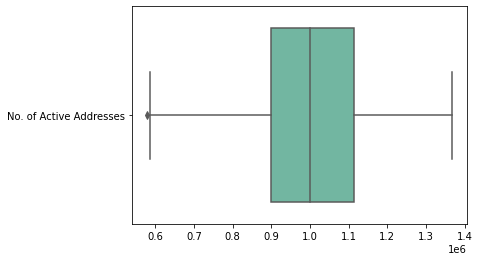

In [44]:
ax2 = sns.boxplot(data=train[feature_Boxplot2], orient="h", palette="Set2")

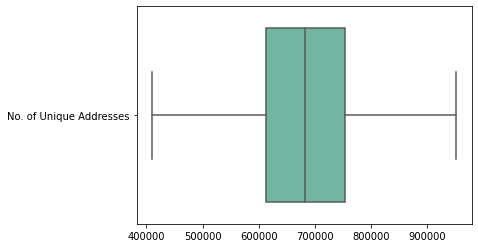

In [45]:
ax3 = sns.boxplot(data=train[feature_Boxplot3], orient="h", palette="Set2")

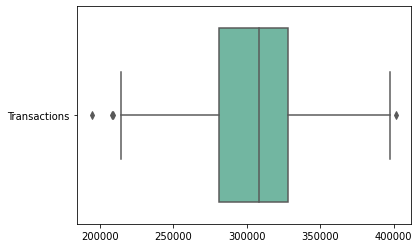

In [46]:
ax4 = sns.boxplot(data=train[feature_Boxplot4], orient="h", palette="Set2")

## EDA

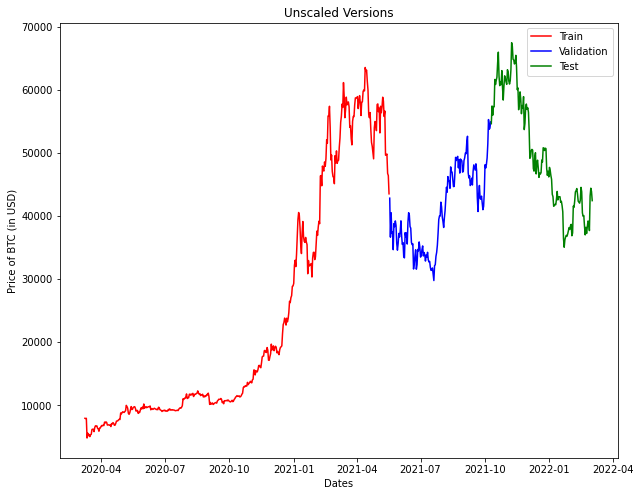

In [47]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

plt.plot(train_time, train['Close'], label = 'Train', color = 'r')
plt.plot(val_time, val['Close'], label = 'Validation',  color = 'b')
plt.plot(test_time, test['Close'], label = 'Test',  color = 'g')
plt.ylabel("Price of BTC (in USD)")
plt.xlabel("Dates")
plt.title("Unscaled Versions")
plt.legend()
plt.show()

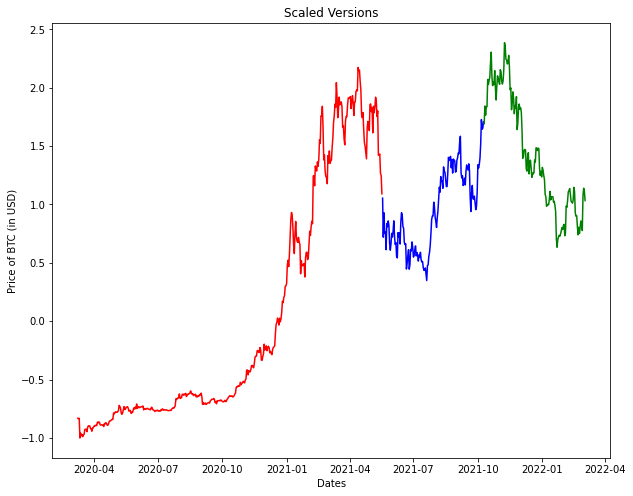

In [48]:

plt.plot(train_time, train_scaled['Close'], label = 'Train', color = 'r')
plt.plot(val_time, val_scaled['Close'], label = 'Validation',  color = 'b')
plt.plot(test_time, test_scaled['Close'], label = 'Test',  color = 'g')
plt.ylabel("Price of BTC (in USD)")
plt.xlabel("Dates")
plt.title("Scaled Versions")
plt.show()